In [1]:
setwd('/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1009. NC ENVRIOSCAN/P1009.3. Analyses/P1009.3.5. Mapping')
cur_date = "021023"

library(readxl)
library(tidyverse)
library(reshape2)
library(sf)
library(tigris)
library(patchwork)
library(rcartocolor)
library(MetBrewer)

# reading in files
whp_df = data.frame(read_excel("Input/Wildfire_Hazard_010523.xlsx"))
ej_screen_geo_id_clusters = data.frame(read_excel("Input/GEO_ID_Sociodemographic_Clusters_020923.xlsx"))
housing_geo_id_clusters = data.frame(read_excel("Input/GEO_ID_Housing_Clusters_020923.xlsx"))

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths


Linking to GEOS 3.11.0, GDAL 3.5.2, PROJ 9.0.1; sf_use_s2() is TRUE


Linked against: 3.11.0-CAPI-1.17.0 compiled against: 3.10.3-CAPI-1.16.1

It is probably a good idea to reinstall sf, and maybe rgeos and rgdal too

To enable caching of data, set `options(tigris_use_cache = TRUE)`
in your R script or .Rprofile.



In [2]:
head(whp_df)

,GEO_ID,FIPS,County,Census_Tract,Avg_ACRES,Wildfire_Hazard_Potential_Mean,Wildfire_Hazard_Potential_Quintile_Number,Wildfire_Hazard_Potential_Quintile_Percentage
,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,14000US37141920201,37141920201,Pender,9202.01,596842.6,715.5177,5,0-20%
2,14000US37141920401,37141920401,Pender,9204.01,596842.6,715.5177,5,0-20%
3,14000US37141920402,37141920402,Pender,9204.02,596842.6,715.5177,5,0-20%
4,14000US37141920403,37141920403,Pender,9204.03,596842.6,715.5177,5,0-20%
5,14000US37141920601,37141920601,Pender,9206.01,596842.6,715.5177,5,0-20%
6,14000US37141990100,37141990100,Pender,9901.00,596842.6,715.5177,5,0-20%


In [3]:
# download shapefile from the tigris (census package)
nc_census_tract_shapefile = tracts(state = 37, year = 2010) %>%
    rename(FIPS = GEOID10)
nc_county_shapefile = counties(state = 37, year = 2010) %>%
    rename(FIPS = GEOID10)
head(nc_census_tract_shapefile)

  |======================================================================| 100%
  |======================================================================| 100%


Registered S3 method overwritten by 'geojsonsf':
  method        from   
  print.geojson geojson



,STATEFP10,COUNTYFP10,TRACTCE10,FIPS,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,COUNTYFP,STATEFP,geometry
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<MULTIPOLYGON [°]>
1,37,153,970100,37153970100,9701,Census Tract 9701,G5020,S,246281647,2106825,+35.0503203,-079.6180454,153,37,MULTIPOLYGON (((-79.56729 3...
2,37,153,970200,37153970200,9702,Census Tract 9702,G5020,S,457736198,7835811,+35.0967892,-079.8225512,153,37,MULTIPOLYGON (((-79.71753 3...
3,37,153,970800,37153970800,9708,Census Tract 9708,G5020,S,139358521,2752112,+34.8508484,-079.8201950,153,37,MULTIPOLYGON (((-79.76773 3...
4,37,153,970900,37153970900,9709,Census Tract 9709,G5020,S,23311020,78240,+34.8785679,-079.7346295,153,37,MULTIPOLYGON (((-79.76773 3...
5,37,153,971000,37153971000,9710,Census Tract 9710,G5020,S,49233222,188190,+34.9395795,-079.6628977,153,37,MULTIPOLYGON (((-79.69038 3...
6,37,153,971100,37153971100,9711,Census Tract 9711,G5020,S,161136716,948938,+34.8751742,-079.6567146,153,37,MULTIPOLYGON (((-79.5684 34...


In [4]:
# first changing data type of some of the columns
whp_df$FIPS = as.character(whp_df$FIPS)
ej_screen_geo_id_clusters$Cluster_3 = as.character(ej_screen_geo_id_clusters$Cluster_3)
housing_geo_id_clusters$Cluster_3 = as.character(housing_geo_id_clusters$Cluster_3)
ej_screen_geo_id_clusters$Cluster_4 = as.character(ej_screen_geo_id_clusters$Cluster_4)
housing_geo_id_clusters$Cluster_4 = as.character(housing_geo_id_clusters$Cluster_4)

# combining data
all_data_census_tract = full_join(whp_df, nc_census_tract_shapefile)
all_data_census_tract$Wildfire_Hazard_Potential_Quintile_Number = as.character(all_data_census_tract$Wildfire_Hazard_Potential_Quintile_Number)


# need to first make sure files are the same dimensions
county_averages_df = whp_df %>%
    group_by(County) %>%
    mutate(County_Avg_WHP_Mean = mean(Wildfire_Hazard_Potential_Mean), 
           County_Avg_WHP_Quintile = mean(Wildfire_Hazard_Potential_Quintile_Number)) %>%
    select(County, County_Avg_WHP_Mean, County_Avg_WHP_Quintile)

all_data_county = full_join(county_averages_df, nc_county_shapefile %>%
                                rename(County = NAME10))



head(all_data_census_tract)

Joining, by = "FIPS"
Joining, by = "County"


,GEO_ID,FIPS,County,Census_Tract,Avg_ACRES,Wildfire_Hazard_Potential_Mean,Wildfire_Hazard_Potential_Quintile_Number,Wildfire_Hazard_Potential_Quintile_Percentage,STATEFP10,COUNTYFP10,⋯,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,COUNTYFP,STATEFP,geometry
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<MULTIPOLYGON [°]>
1,14000US37141920201,37141920201,Pender,9202.01,596842.6,715.5177,5,0-20%,37,141,⋯,Census Tract 9202.01,G5020,S,21147417,44942,+34.4018480,-077.6218025,141,37,MULTIPOLYGON (((-77.66061 3...
2,14000US37141920401,37141920401,Pender,9204.01,596842.6,715.5177,5,0-20%,37,141,⋯,Census Tract 9204.01,G5020,S,75755882,15209,+34.5055979,-077.9462191,141,37,MULTIPOLYGON (((-77.94007 3...
3,14000US37141920402,37141920402,Pender,9204.02,596842.6,715.5177,5,0-20%,37,141,⋯,Census Tract 9204.02,G5020,S,65209545,12064,+34.5702392,-077.9912005,141,37,MULTIPOLYGON (((-77.92338 3...
4,14000US37141920403,37141920403,Pender,9204.03,596842.6,715.5177,5,0-20%,37,141,⋯,Census Tract 9204.03,G5020,S,106488713,1076000,+34.5493899,-077.8690183,141,37,MULTIPOLYGON (((-77.83308 3...
5,14000US37141920601,37141920601,Pender,9206.01,596842.6,715.5177,5,0-20%,37,141,⋯,Census Tract 9206.01,G5020,S,103459422,348628,+34.4486577,-077.9634232,141,37,MULTIPOLYGON (((-77.94027 3...
6,14000US37141990100,37141990100,Pender,9901.00,596842.6,715.5177,5,0-20%,37,141,⋯,Census Tract 9901,G5020,S,0,133298842,+34.3492469,-077.6031266,141,37,MULTIPOLYGON (((-77.67696 3...


Creating 4 different maps of North Carolina:

1. WHP mean by GEO id
2. WHP quintile by GEO id
3. WHP mean by County
4. WHP quintile by County
5. Clusters based on EJ Screen social stressors by GEO id
6. Clusters based on housing data by GEO id

### WHP Mean by GEO id

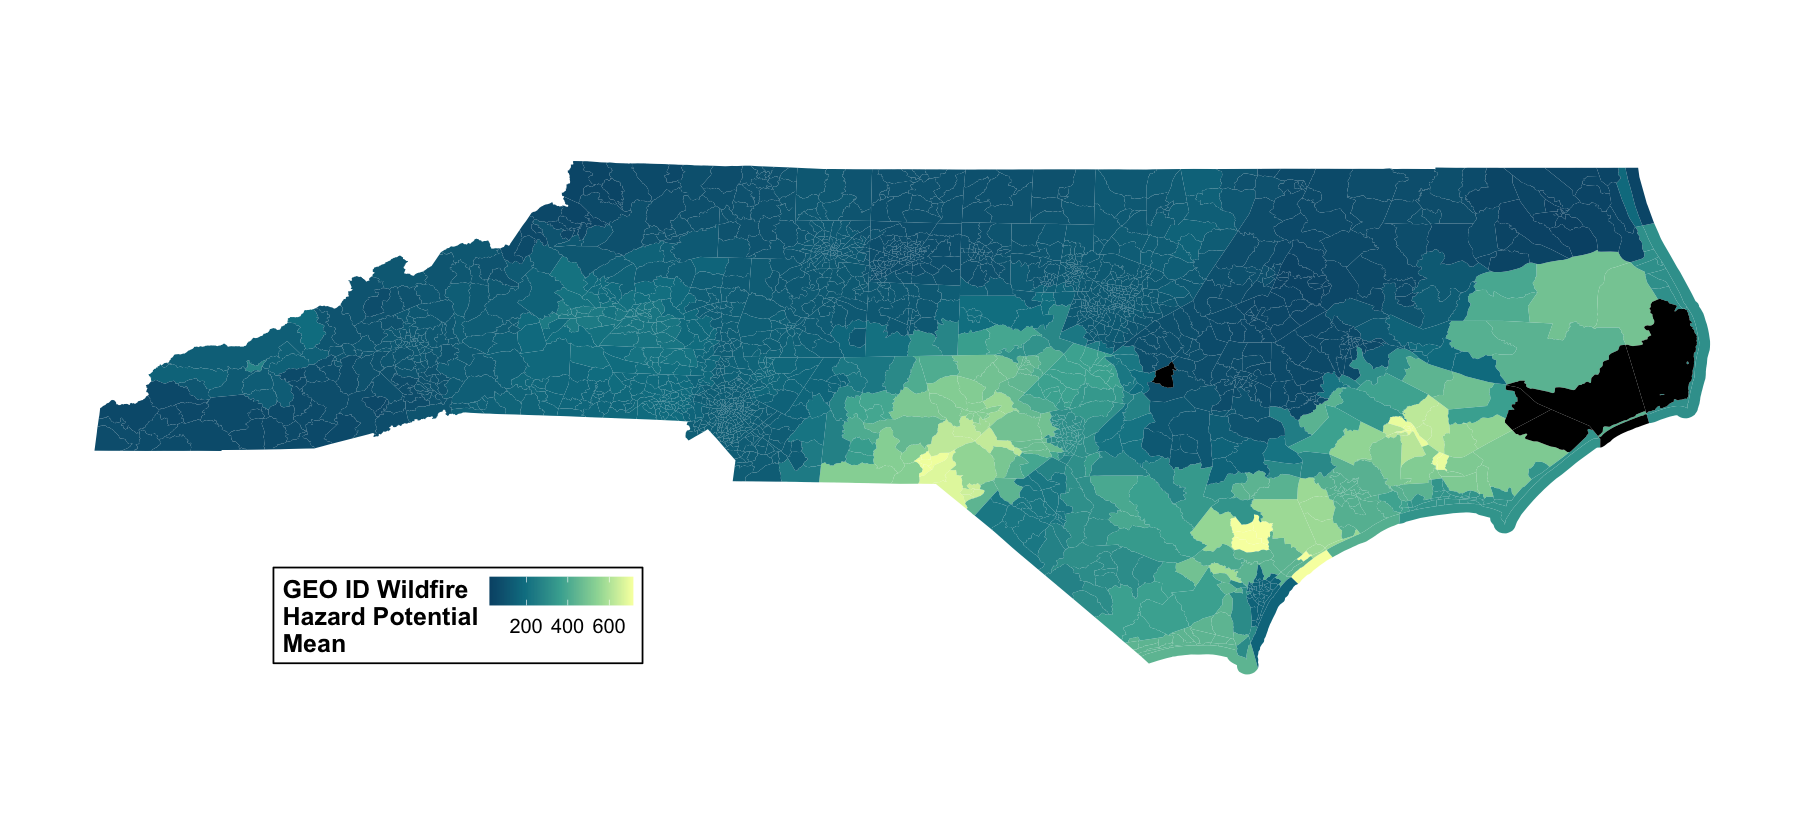

In [5]:
options(repr.plot.width=15, repr.plot.height=7) #changing size

# getting color palette
palette_colors = rev(carto_pal(5, "BluYl"))

WHP_mean_GEO_ID_map = ggplot() +
  geom_sf(data = all_data_census_tract, aes(fill = Wildfire_Hazard_Potential_Mean, geometry = geometry), 
          color = NA) + # removes gray lines between geo ids

  theme_bw() + 

  theme(axis.text = element_blank(), # removes x and y labels
      axis.ticks = element_blank(),# removes ticks from x and y labels
      legend.title = element_text(face = 'bold', size = 15), # changes legend title
      legend.text = element_text(size = 12), # changes legend text
      legend.position = c(0.25,0.15), # move legend to bottom left corner
      legend.direction = "horizontal",
      legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
      panel.border = element_blank(), # removes border around the map
      panel.grid.major = element_blank(), # removes grid
      panel.grid.minor = element_blank()) + # removes grid 
  
  scale_fill_gradientn(colors = palette_colors, 
                       na.value = "black", # making geo ids w/ NA values black
      # another color option
      #low = "#1f4260", mid = "#007e92", high = "#ffffcc", 
      name = "GEO ID Wildfire\nHazard Potential\nMean")
WHP_mean_GEO_ID_map

### WHP Quintile by GEO id

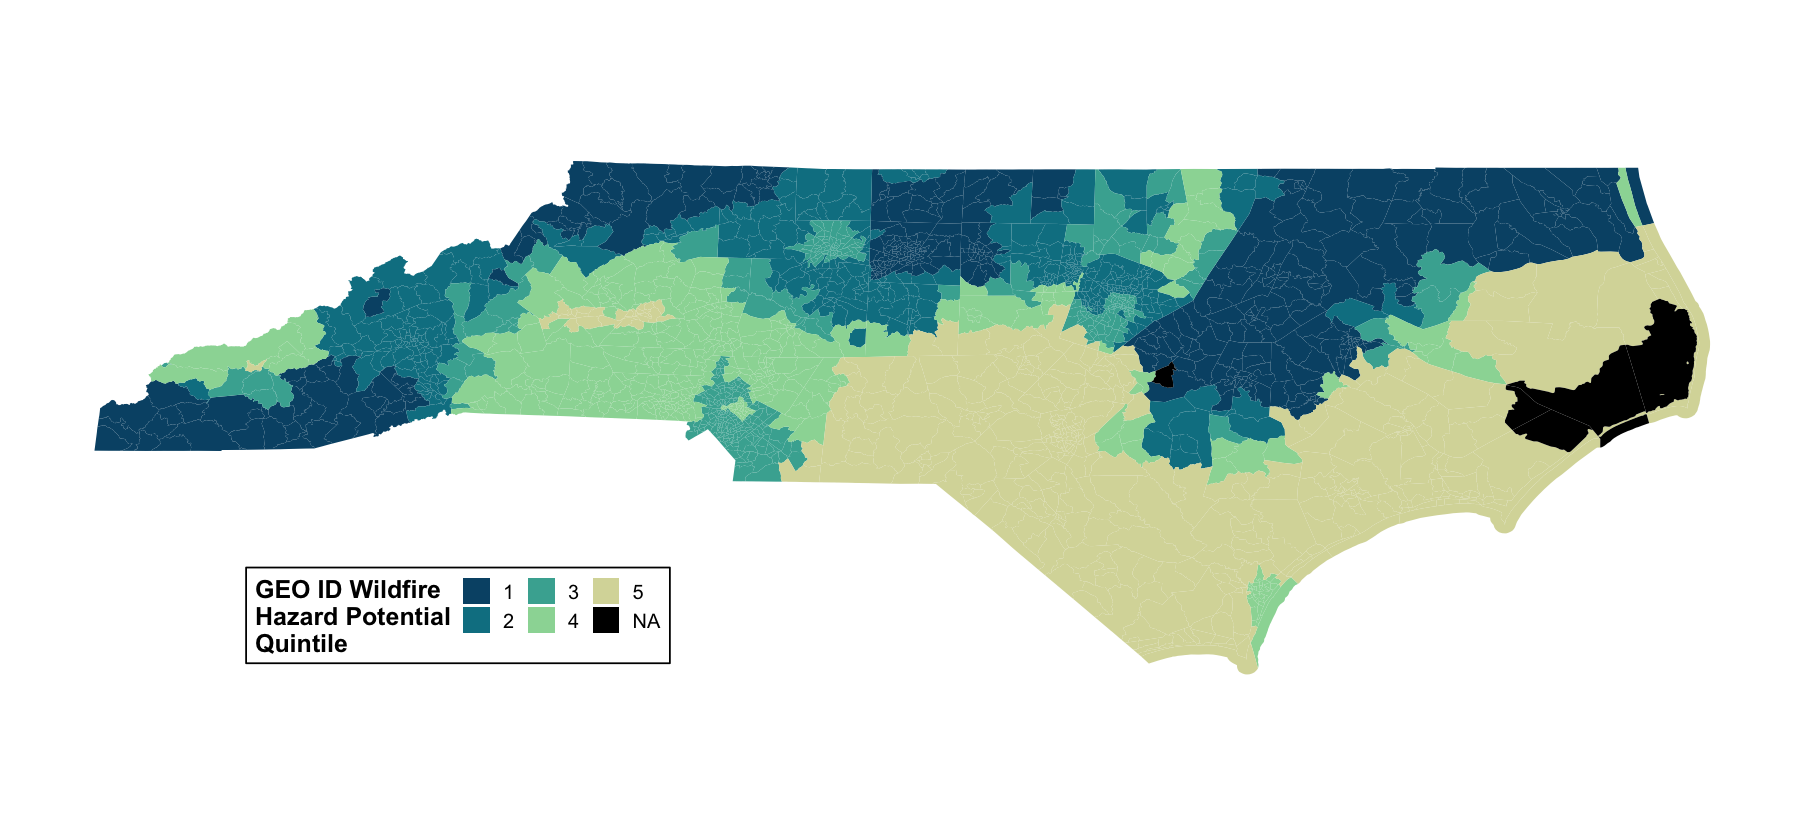

In [6]:
WHP_quintile_GEO_ID_map = ggplot() +
  geom_sf(data = all_data_census_tract, aes(fill = Wildfire_Hazard_Potential_Quintile_Number, 
                                            geometry = geometry), color = NA) + # removes gray lines between geo ids

  theme_bw() + 

  theme(axis.text = element_blank(), # removes x and y labels
      axis.ticks = element_blank(),# removes ticks from x and y labels
      legend.title = element_text(face = 'bold', size = 15), # changes legend title
      legend.text = element_text(size = 12), # changes legend text
      legend.position = c(0.25,0.15), # move legend to bottom left corner
      legend.direction = "horizontal",
      legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
      panel.border = element_blank(), # removes border around the map
      panel.grid.major = element_blank(), # removes grid
      panel.grid.minor = element_blank()) + # removes grid 

  scale_fill_manual(values = c(palette_colors[1:4], '#d8d9a7'), na.value = "black", 
                       name = "GEO ID Wildfire\nHazard Potential\nQuintile")

WHP_quintile_GEO_ID_map

### WHP Mean by County

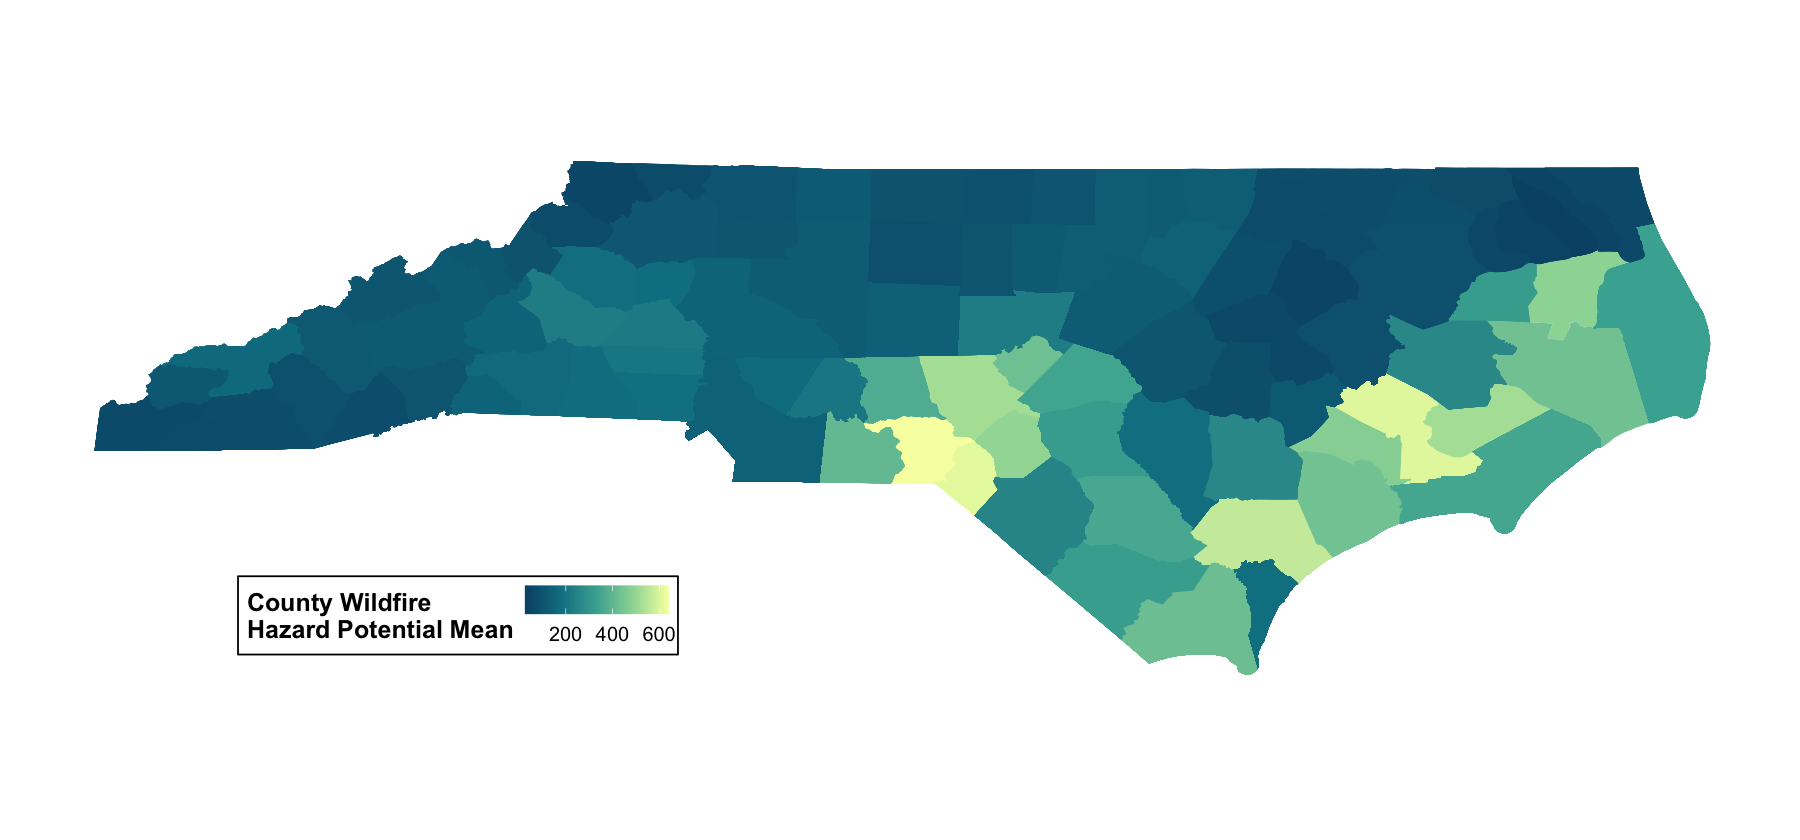

In [7]:
options(repr.plot.width=15, repr.plot.height=7) #changing size
WHP_mean_county_map = ggplot() +
  geom_sf(data = all_data_county, aes(fill = County_Avg_WHP_Mean, geometry = geometry),
          color = NA) + # removes gray lines between geo ids

  theme_bw() + 

  theme(axis.text = element_blank(), # removes x and y labels
      axis.ticks = element_blank(),# removes ticks from x and y labels
      legend.title = element_text(face = 'bold', size = 15), # changes legend title
      legend.text = element_text(size = 12), # changes legend text
      legend.position = c(0.25,0.15), # move legend to bottom left corner
      legend.direction = "horizontal",
      legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
      panel.border = element_blank(), # removes border around the map
      panel.grid.major = element_blank(), # removes grid
      panel.grid.minor = element_blank()) + # removes grid 
  
  scale_fill_gradientn(colors = palette_colors, 
      name = "County Wildfire\nHazard Potential Mean")

WHP_mean_county_map

### WHP Quintile by County

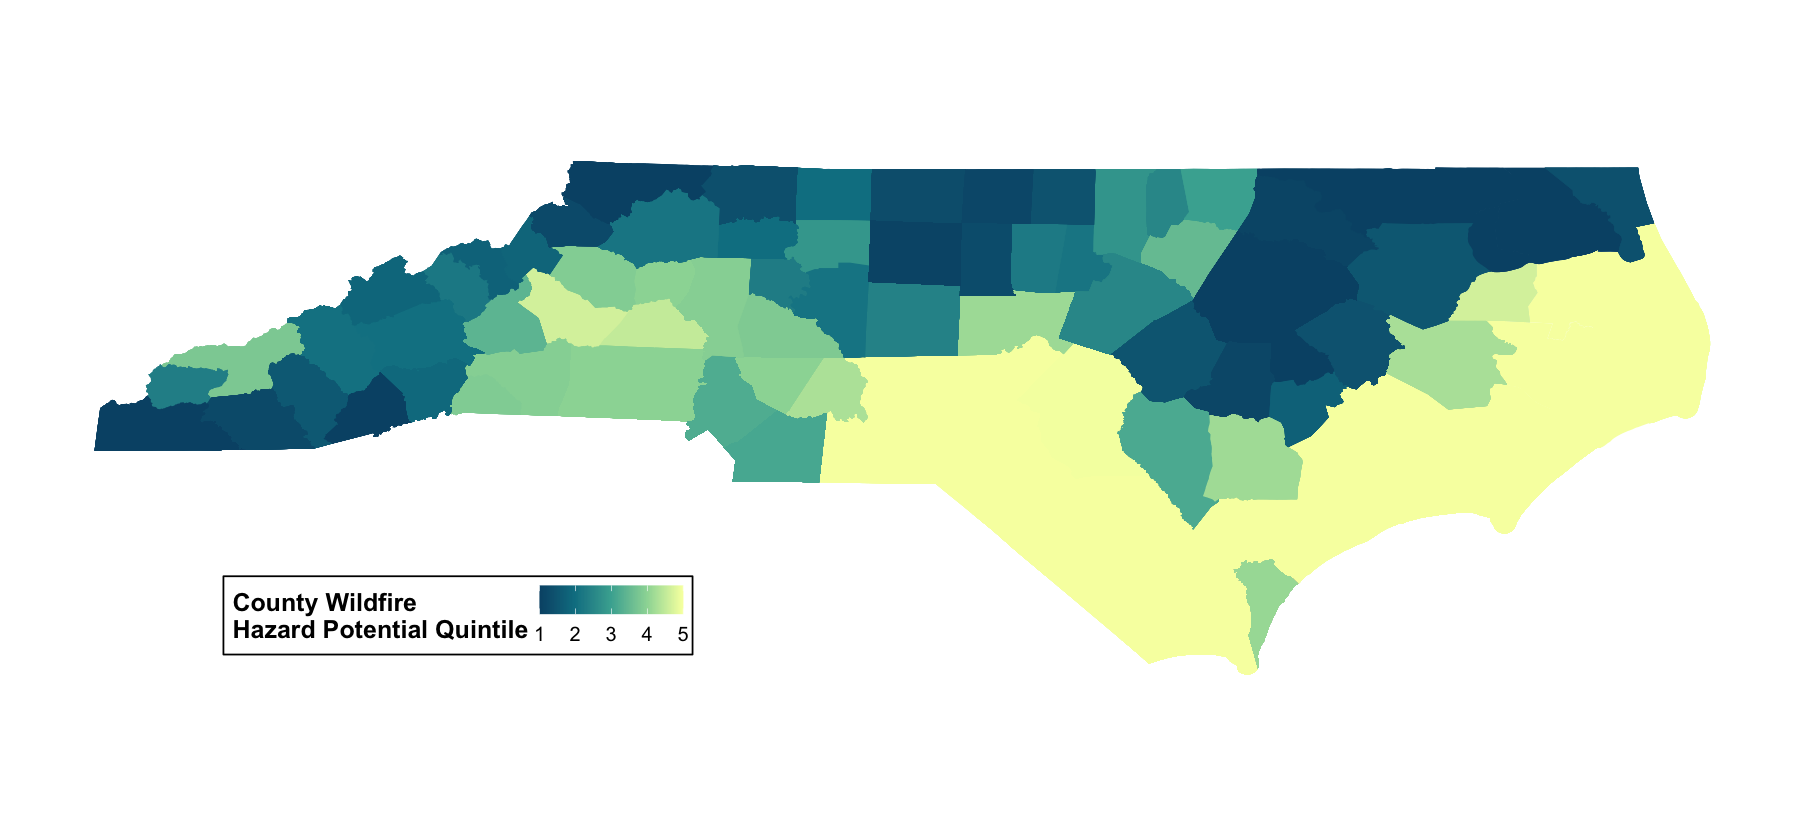

In [8]:
options(repr.plot.width=15, repr.plot.height=7) #changing size
WHP_quintile_county_map = ggplot() +
  geom_sf(data = all_data_county, aes(fill = County_Avg_WHP_Quintile, geometry = geometry), color = NA) + 
  theme_bw() + 

 theme(axis.text = element_blank(), # removes x and y labels
      axis.ticks = element_blank(),# removes ticks from x and y labels
      legend.title = element_text(face = 'bold', size = 15), # changes legend title
      legend.text = element_text(size = 12), # changes legend text
      legend.position = c(0.25,0.15), # move legend to bottom left corner
      legend.direction = "horizontal",
      legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
      panel.border = element_blank(), # removes border around the map
      panel.grid.major = element_blank(), # removes grid
      panel.grid.minor = element_blank()) + # removes grid 
  
  scale_fill_gradientn(colors = palette_colors,
      name = "County Wildfire\nHazard Potential Quintile")

WHP_quintile_county_map

# WHP Maps

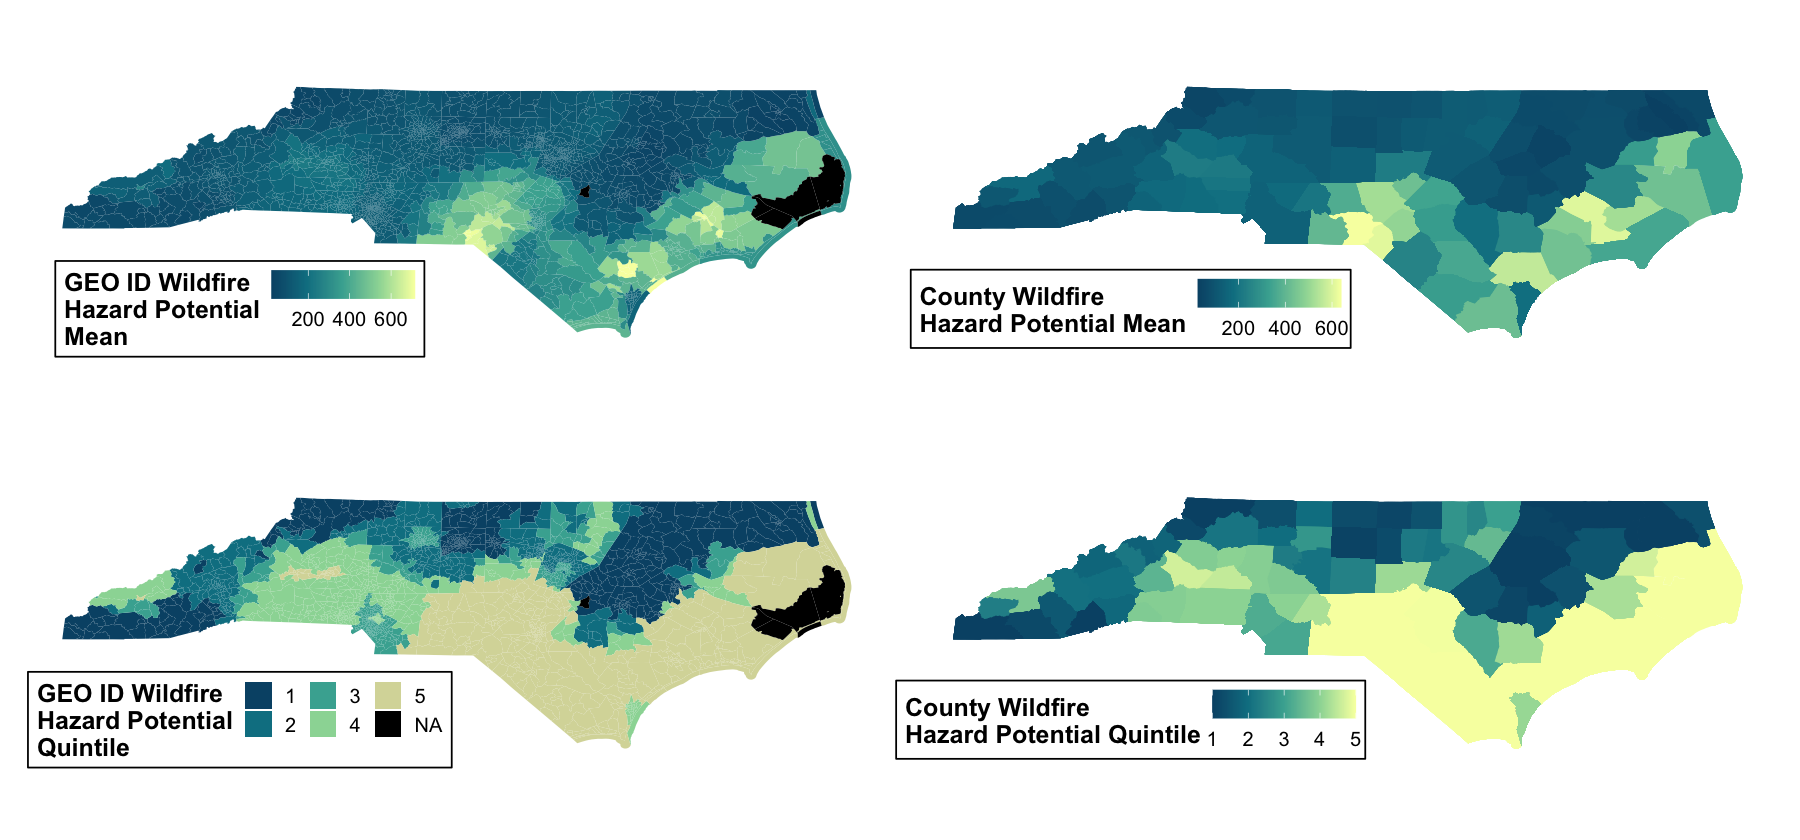

In [9]:
WHP_mean_GEO_ID_map + WHP_mean_county_map + WHP_quintile_GEO_ID_map + WHP_quintile_county_map +
plot_layout(height = c(6,6))

# GEO ID clustering using EJ Screen Indicators

In [10]:
# adding in clusters
ej_screen_df = full_join(all_data_census_tract, ej_screen_geo_id_clusters)
head(ej_screen_df)

Joining, by = "GEO_ID"


,GEO_ID,FIPS,County,Census_Tract,Avg_ACRES,Wildfire_Hazard_Potential_Mean,Wildfire_Hazard_Potential_Quintile_Number,Wildfire_Hazard_Potential_Quintile_Percentage,STATEFP10,COUNTYFP10,⋯,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,COUNTYFP,STATEFP,geometry,Cluster_3,Cluster_4
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<MULTIPOLYGON [°]>,<chr>,<chr>
1,14000US37141920201,37141920201,Pender,9202.01,596842.6,715.5177,5,0-20%,37,141,⋯,S,21147417,44942,+34.4018480,-077.6218025,141,37,MULTIPOLYGON (((-77.66061 3...,1,3
2,14000US37141920401,37141920401,Pender,9204.01,596842.6,715.5177,5,0-20%,37,141,⋯,S,75755882,15209,+34.5055979,-077.9462191,141,37,MULTIPOLYGON (((-77.94007 3...,3,2
3,14000US37141920402,37141920402,Pender,9204.02,596842.6,715.5177,5,0-20%,37,141,⋯,S,65209545,12064,+34.5702392,-077.9912005,141,37,MULTIPOLYGON (((-77.92338 3...,1,4
4,14000US37141920403,37141920403,Pender,9204.03,596842.6,715.5177,5,0-20%,37,141,⋯,S,106488713,1076000,+34.5493899,-077.8690183,141,37,MULTIPOLYGON (((-77.83308 3...,1,4
5,14000US37141920601,37141920601,Pender,9206.01,596842.6,715.5177,5,0-20%,37,141,⋯,S,103459422,348628,+34.4486577,-077.9634232,141,37,MULTIPOLYGON (((-77.94027 3...,2,1
6,14000US37141990100,37141990100,Pender,9901.00,596842.6,715.5177,5,0-20%,37,141,⋯,S,0,133298842,+34.3492469,-077.6031266,141,37,MULTIPOLYGON (((-77.67696 3...,NA,NA


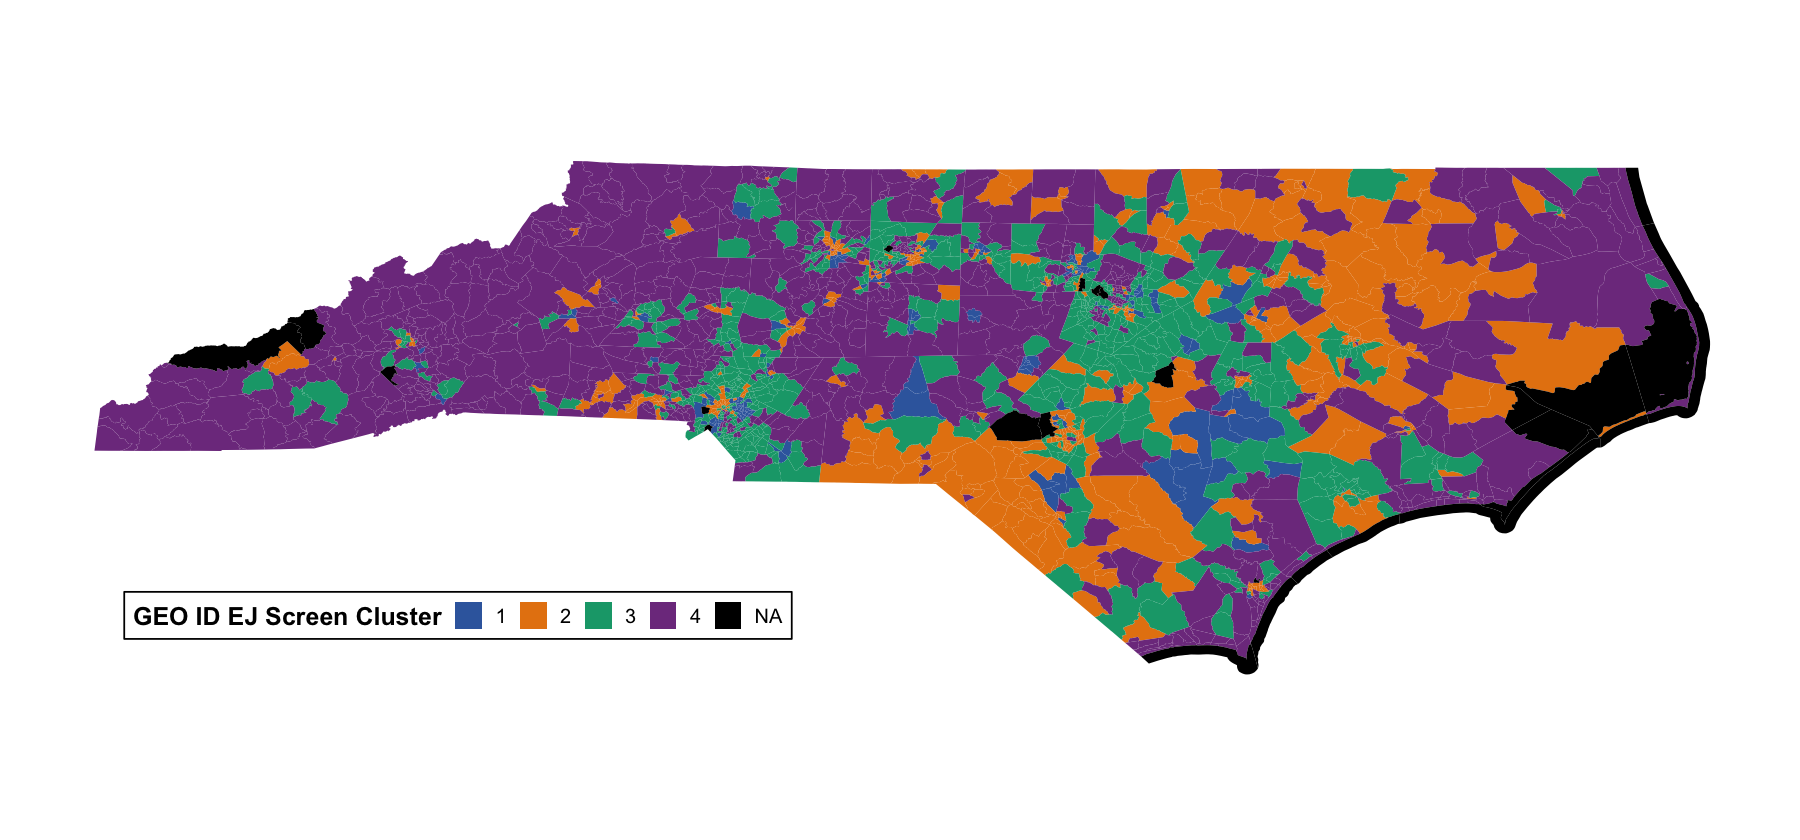

In [12]:
options(repr.plot.width=15, repr.plot.height=7) #changing size

# getting color palette
prism_colors = carto_pal(12, "Bold")
peru_palette = MetPalettes$Peru1[[1]]

ej_screen_GEO_ID_map = ggplot() +
  geom_sf(data = ej_screen_df, aes(fill = Cluster_4, geometry = geometry), 
          color = NA) + # removes gray lines between geo ids

  theme_bw() + 

    theme(axis.text = element_blank(), # removes x and y labels
      axis.ticks = element_blank(),# removes ticks from x and y labels
      legend.title = element_text(face = 'bold', size = 15), # changes legend title
      legend.text = element_text(size = 12), # changes legend text
      legend.position = c(0.25,0.15), # move legend to bottom left corner
      legend.direction = "horizontal",
      legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
      panel.border = element_blank(), # removes border around the map
      panel.grid.major = element_blank(), # removes grid
      panel.grid.minor = element_blank()) + # removes grid 

  scale_fill_manual(values = prism_colors[c(3,7,2,1)], #peru_palette[c(2,3,5,6)],
                    na.value = "black", # making geo ids w/ NA values black
                    name = "GEO ID EJ Screen Cluster")


ej_screen_GEO_ID_map

# GEO ID clustering using Housing Indicators

In [13]:
# adding in clusters
housing_clusters_geometry_df = full_join(all_data_census_tract, housing_geo_id_clusters)
head(housing_clusters_geometry_df)

Joining, by = "GEO_ID"


,GEO_ID,FIPS,County,Census_Tract,Avg_ACRES,Wildfire_Hazard_Potential_Mean,Wildfire_Hazard_Potential_Quintile_Number,Wildfire_Hazard_Potential_Quintile_Percentage,STATEFP10,COUNTYFP10,⋯,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,COUNTYFP,STATEFP,geometry,Cluster_3,Cluster_4
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<MULTIPOLYGON [°]>,<chr>,<chr>
1,14000US37141920201,37141920201,Pender,9202.01,596842.6,715.5177,5,0-20%,37,141,⋯,S,21147417,44942,+34.4018480,-077.6218025,141,37,MULTIPOLYGON (((-77.66061 3...,2,4
2,14000US37141920401,37141920401,Pender,9204.01,596842.6,715.5177,5,0-20%,37,141,⋯,S,75755882,15209,+34.5055979,-077.9462191,141,37,MULTIPOLYGON (((-77.94007 3...,2,3
3,14000US37141920402,37141920402,Pender,9204.02,596842.6,715.5177,5,0-20%,37,141,⋯,S,65209545,12064,+34.5702392,-077.9912005,141,37,MULTIPOLYGON (((-77.92338 3...,2,3
4,14000US37141920403,37141920403,Pender,9204.03,596842.6,715.5177,5,0-20%,37,141,⋯,S,106488713,1076000,+34.5493899,-077.8690183,141,37,MULTIPOLYGON (((-77.83308 3...,2,3
5,14000US37141920601,37141920601,Pender,9206.01,596842.6,715.5177,5,0-20%,37,141,⋯,S,103459422,348628,+34.4486577,-077.9634232,141,37,MULTIPOLYGON (((-77.94027 3...,2,3
6,14000US37141990100,37141990100,Pender,9901.00,596842.6,715.5177,5,0-20%,37,141,⋯,S,0,133298842,+34.3492469,-077.6031266,141,37,MULTIPOLYGON (((-77.67696 3...,NA,NA


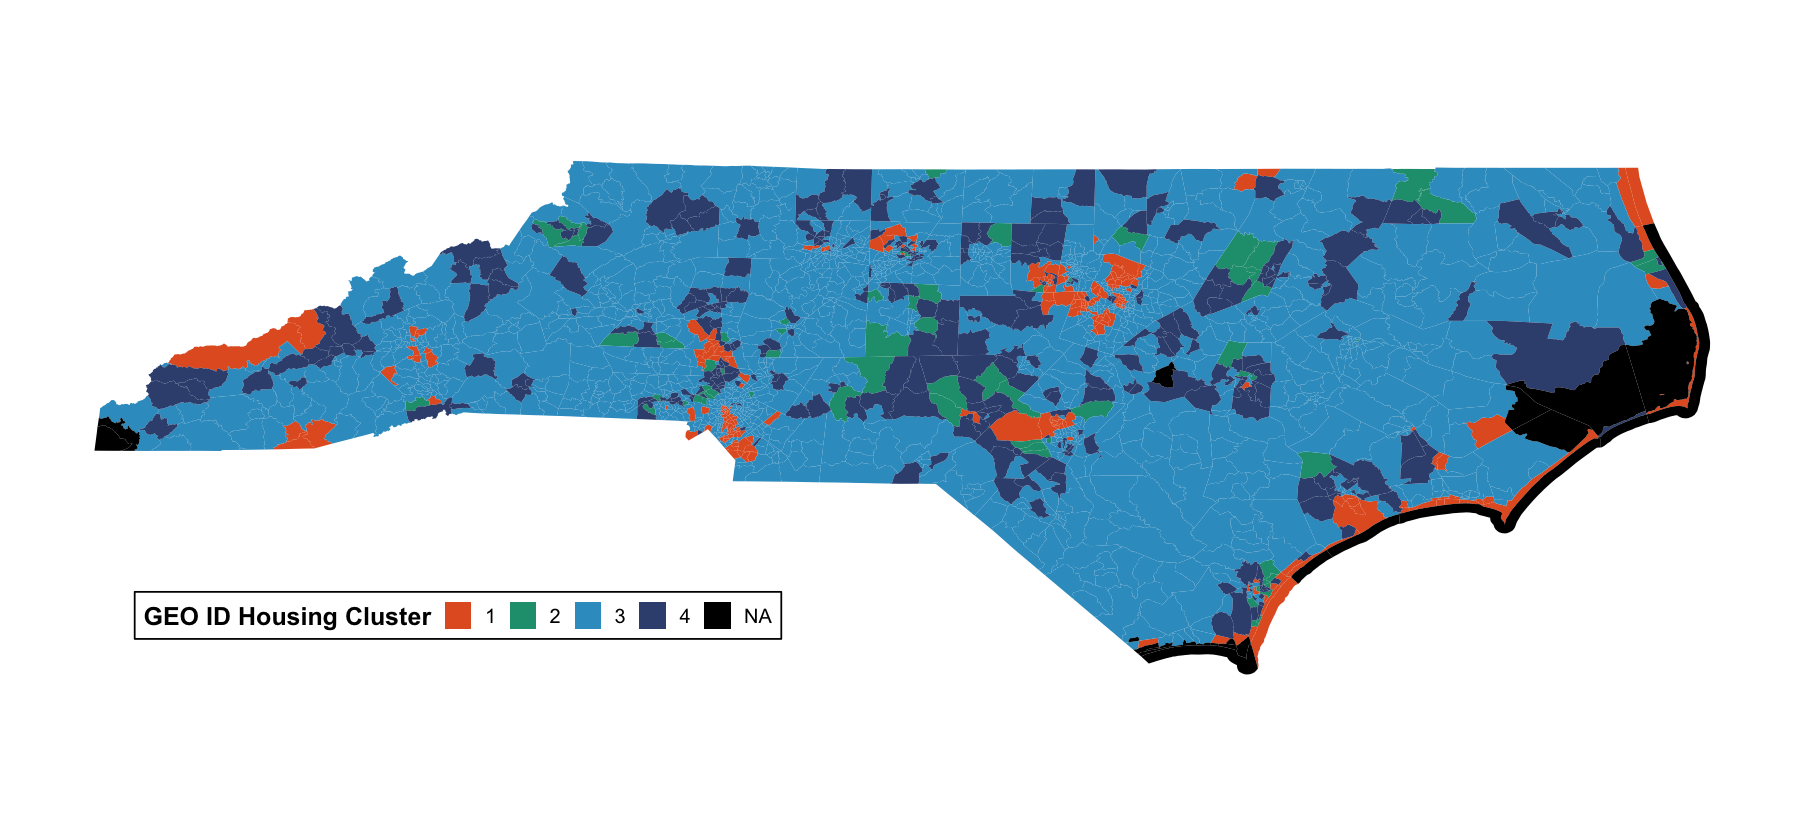

In [14]:
# getting color palette
# prism_colors = carto_pal(12, "Bold")
# peru_palette = MetPalettes$Peru1[[1]]

housing_GEO_ID_map = ggplot() +
  geom_sf(data = housing_clusters_geometry_df, aes(fill = Cluster_4, geometry = geometry), 
          color = NA) + # removes gray lines between geo ids

  theme_bw() + 

    theme(axis.text = element_blank(), # removes x and y labels
      axis.ticks = element_blank(),# removes ticks from x and y labels
      legend.title = element_text(face = 'bold', size = 15), # changes legend title
      legend.text = element_text(size = 12), # changes legend text
      legend.position = c(0.25,0.15), # move legend to bottom left corner
      legend.direction = "horizontal",
      legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
      panel.border = element_blank(), # removes border around the map
      panel.grid.major = element_blank(), # removes grid
      panel.grid.minor = element_blank()) + # removes grid 

  scale_fill_manual(values = peru_palette[c(2,3,5,6)],#prism_colors[c(3,7,2,1)], 
                    na.value = "black", # making geo ids w/ NA values black
                    name = "GEO ID Housing Cluster")


housing_GEO_ID_map

# Are areas of social stress & housing outcomes associated with areas of higher WHP risk?

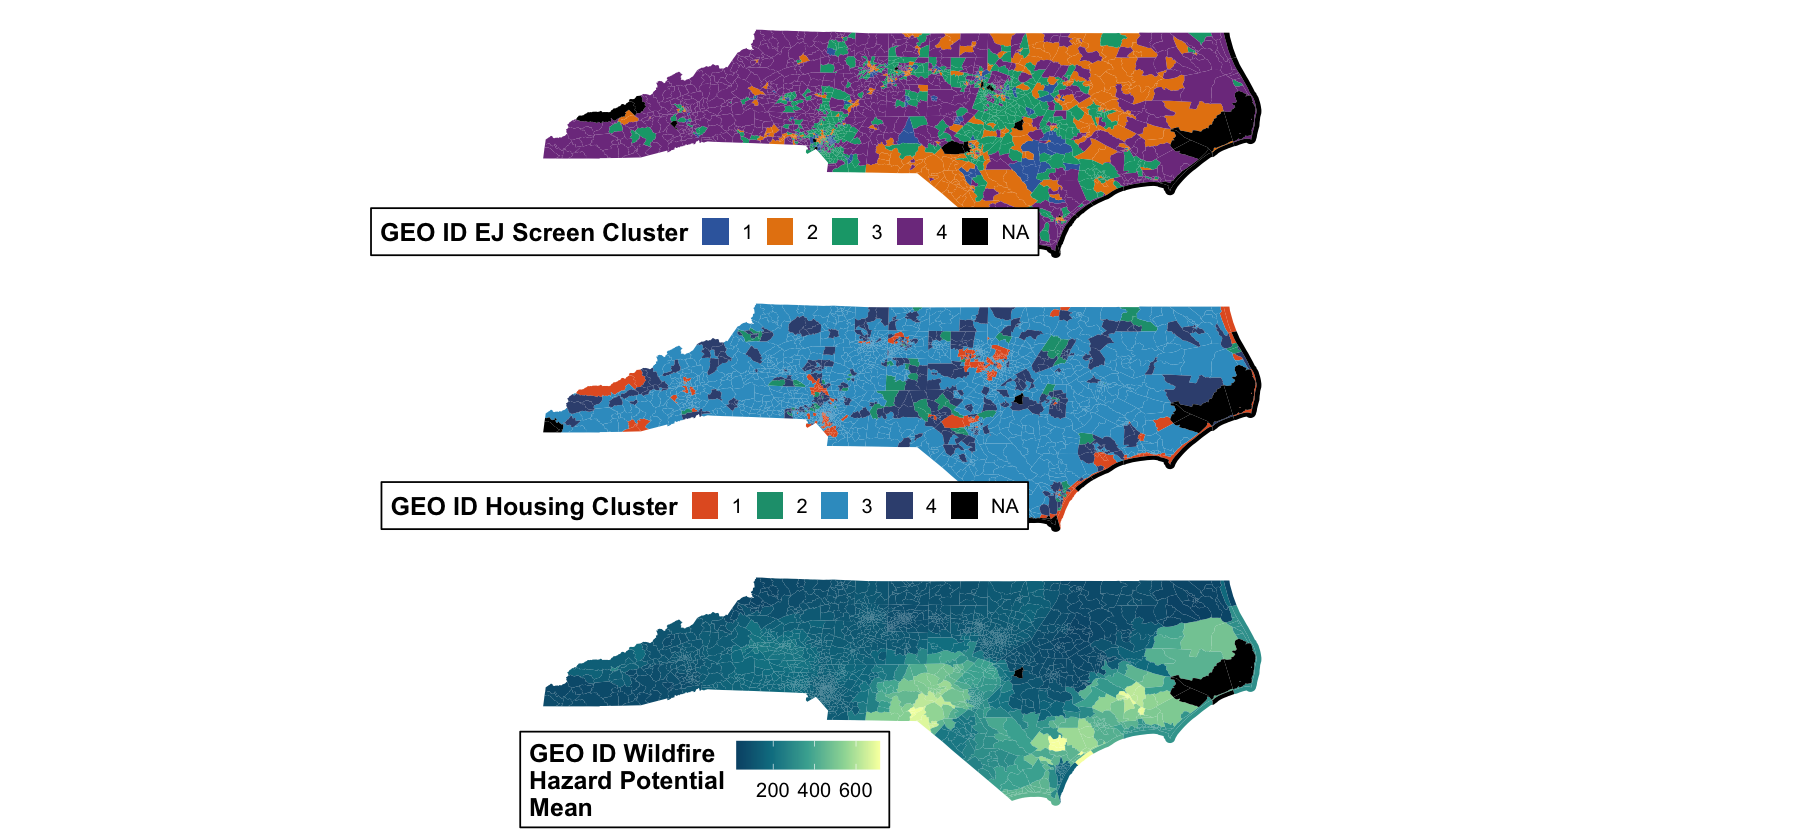

In [15]:
ej_screen_GEO_ID_map + housing_GEO_ID_map + WHP_mean_GEO_ID_map + plot_layout(ncol = 1)

Not really, but we also don't yet know the directionality of the sociodemographic variables that are driving the clusters.